# AT&T spam detector

The objective of this project is to create a spam detector, based on a dataset with labels "spam" or "ham"(being non spams).

We are thus dealing with prediction on non structured elements being text. In this context Natural Language Processing with deep learning will be applied.

# Content
- 1- Data exploration
  - 1-1 Weight of labels in the target
  - 1-2 "Unnamed:" columns
- 2- Text preprocessing
- 3- Prepare model
- 4- Base model
  - 4-1 Base model building
  - 4-2 Evaluation of base model
  - 4-3 Reduce overfitting on base model
  - 4-4 Evaluation of base model tuned
- 5- Transfer learning with BERT
  - 5-1 Building model
  - 5-2 Evaluate model
- Conclusion

In [1]:
# Working on colab, need to re-install libraries. Can be ignored if already installed
!pip install -U "tensorflow==2.8.*"
!pip install -U "tensorflow-text==2.8.*"
!python -m spacy download en_core_web_md -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing

In [2]:
import pandas as pd 
import numpy as np
import io
import os

import plotly.express as px
import matplotlib.pyplot as plt

import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Import Dataset

In [3]:
df = pd.read_csv('/content/spam.csv',encoding = "ISO-8859-1")

# 1- Data exploration

In [4]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

- v1 Column is the target
- The features "Unnamed:2", "Unnamed:3", "Unnamed:4" need to be further explored to understand what they are. Many missing data here
- Text processing will have to be done to treat spaces, high/lowercases, lemmatize etc

## 1-1 Weight of labels in the target

In [5]:
count = df.value_counts("v1")
fig = px.pie(df, values=count, names = count.index, title='Ham/spam proportion')
fig.show()

- The dataset is imbalanced; this needs to be taken into consideration at a later stage, by using a stratify in the train/test split and the metrics that will be used

## 1-2 "Unnamed :" columns

- Let's consider column "Unnamed: 2" that have data and compare the len of column "v2", to see if column "Unnamed: 2" could be the continuation of column "v2"

In [6]:
filtered_Unnamed2 = df[df["Unnamed: 2"].notnull()].copy()
filtered_Unnamed2["len_v2"] = len(filtered_Unnamed2["v2"])
filtered_Unnamed2.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,len_v2
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN,50
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve..""",50
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN,50
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN,50
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN,50


In [7]:
filtered_Unnamed2["len_v2"].unique()

array([50])

- "Unnamed: 2" column is populated only when column "v2" contains 50 characters.
It seems thus that column "Unnamed: 2" is indeed the continuation of the message when the first 50 characters are full.

- Let's check this assumption by considering column "Unnamed: 3" having data and compare to the len of column "Unnamed: 2"

In [8]:
filtered_Unnamed3 = df[df["Unnamed: 3"].notnull()].copy()
filtered_Unnamed3["len_Unnamed: 2"] = len(filtered_Unnamed3["Unnamed: 2"])
filtered_Unnamed3.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,len_Unnamed: 2
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN,12
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve..""",12
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN,12
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)""",12
2170,ham,\CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...,JUST REALLYNEED 2DOCD.PLEASE DONTPLEASE DONTIG...,"U NO THECD ISV.IMPORTANT TOME 4 2MORO\""""",NaN,12


In [9]:
filtered_Unnamed3["len_Unnamed: 2"].unique()

array([12])

- "Unnamed: 3" column is populated only when colum "Unnamed: 2" is complete with 12 characters. "Unnamed: 3" seems then to be the continuation of column "Unnamed: 2".
- Let's also check column "Unnamed: 4"

In [10]:
filtered_Unnamed4 = df[df["Unnamed: 4"].notnull()].copy()
filtered_Unnamed4["len_Unnamed: 3"] = len(filtered_Unnamed4["Unnamed: 3"])
filtered_Unnamed4.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,len_Unnamed: 3
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve..""",6
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)""",6
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe...",6
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\""""",6
4668,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!""",6


In [11]:
filtered_Unnamed4["len_Unnamed: 3"].unique()

array([6])

- Here also column "Unnamed: 4" seems to be the continuation of col "Unnamed: 3" since it is populated only when column "Unnamed: 3" is full with 6 characters

- Let's see the frequency of long messages using several columns to see if these columns will be kept in scope

In [12]:
print (f'Populated rows column "Unnamed: 2" = {filtered_Unnamed2.shape[0]}')
print (f'Populated rows column "Unnamed: 3" = {filtered_Unnamed3.shape[0]}')
print (f'Populated rows column "Unnamed: 4" = {filtered_Unnamed4.shape[0]}')

Populated rows column "Unnamed: 2" = 50
Populated rows column "Unnamed: 3" = 12
Populated rows column "Unnamed: 4" = 6


- Given the small number of populated items in columns "Unnamed: 2", "Unnamed: 3", "Unnamed: 4", these columns will be removed from the database.

- let's drop Unnamed columns:

In [13]:
data = df[["v1", "v2"]]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 2-Text preprocessing

- Let's rename useful columns

In [14]:
data = data.rename(columns = {"v1":"target", "v2":"text"})

- Let's clean up:
  - remove all non alphanumeric characters except whitespaces
  - replace double white spaces with single white spaces
  - convert to lowercase
  - trim starting and finishing whitespaces
  - remove stop words
  - replace every word with their lemma (+/- core word)

In [15]:
nlp = en_core_web_md.load() # medium language version 

In [16]:
data["text_clean"] = data["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" ")) # Remove all non alphanumeric characters except whitespaces
data["text_clean"] = data["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip()) #replace double whitespaces with single whitespaces, 
#convert all characters to lowercase and trim starting and finishing whitespaces
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
# remove stop words and replace everyword with their lemma

data.head()

,target,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


- Adding lenght of text cleaned, to be used later on

In [17]:
data["len_caract"] = data["text_clean"].apply(lambda x: len(x))
data.head()

,target,text,text_clean,len_caract
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,75
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,21
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,131
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,19
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,18


- The above "test_clean" has well been lemmatized and stop words are removed

- Let's now perform a consistency check on the lenght of caracters to remove outliers

In [18]:
data.shape[0]

5572

In [19]:
# removing outliers using a mask:
to_keep_clean_outliers = (np.abs(data['len_caract']-data['len_caract'].mean()) <= (3*data['len_caract'].std()) ) | data['len_caract'].isnull()

In [20]:
data_def = data[to_keep_clean_outliers].reset_index(drop = True)
data_def.shape

(5535, 4)

- Checking NaN

In [21]:
mask = data_def.text_clean.apply(lambda x: type(x)==str) # exclude nan before tokenize
mask.value_counts()

True    5535
Name: text_clean, dtype: int64

- No need to apply the mask since there are no NaN

- Tokenizing text: converting text into figures, here using 1000 different words

In [22]:
tokenizer_text = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer_text.fit_on_texts(data_def.text_clean)
data_def["text_encoded"] = tokenizer_text.texts_to_sequences(data_def.text_clean)

In [23]:
data_def.head()

,target,text,text_clean,len_caract,text_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,75,"[1, 222, 451, 452, 911, 39, 53, 205, 912, 76, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,21,"[10, 190, 453, 284, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,131,"[11, 291, 4, 519, 642, 32, 1, 826, 413, 1, 1, ..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,19,"[2, 122, 152, 1, 2, 80]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,18,"[686, 23, 643, 138]"


- Padding: adding 0 after the tokenized text so that all the sequences have the same lenght

In [24]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(data_def.text_encoded, padding="post") # padding to get all sequences at same len, adding 0

- Encoding target: 1 will be "spam", and 0 will be "no spam"

In [25]:
data_def["target_encoded"] = data_def["target"].apply(lambda x: 1 if x == "spam" else 0)

In [26]:
data_def.head()

,target,text,text_clean,len_caract,text_encoded,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,75,"[1, 222, 451, 452, 911, 39, 53, 205, 912, 76, ...",0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,21,"[10, 190, 453, 284, 2, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,131,"[11, 291, 4, 519, 642, 32, 1, 826, 413, 1, 1, ...",1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,19,"[2, 122, 152, 1, 2, 80]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,18,"[686, 23, 643, 138]",0


# 3- Prepare model

In [27]:
# Train Test Split, using stratify because the dataset is imbalanced
xtrain, xval, ytrain, yval = train_test_split(text_pad,data_def.target_encoded, test_size=0.3,stratify=data_def.target_encoded)

In [28]:
# Tensor
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [29]:
# batch: split the data into random batches -> 1 epoch is one sweep through all the batches
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [30]:
 # looking at a batch
for text, target in train_batch.take(1):
  print(text, target)

tf.Tensor(
[[ 11 291 475 ...   0   0   0]
 [  1   1 751 ...   0   0   0]
 [125  18   3 ...   0   0   0]
 ...
 [ 10  43 320 ...   0   0   0]
 [ 97  17 353 ...   0   0   0]
 [612   1 156 ...   0   0   0]], shape=(64, 29), dtype=int32) tf.Tensor(
[1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0], shape=(64,), dtype=int64)


# 4- Base model

## 4-1 Base model building

Let's build a very simple model 
- An embedding layer is taking the tokens one after the other
- The global Average Pooling aggregates the values of the token for each sequence

- Then the several values of neurons are sent to 2 successive dense layers with activation ReLu.

- The output layer is using a sigmoid activation, that is dedicated to Binary classifications

In [31]:
vocab_size = tokenizer_text.num_words #1000 words in the vocabulary as chosen above

In [32]:
text.shape[1]

29

In [33]:
base_model = tf.keras.Sequential([
                  # layer Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[text.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # dense layer
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # output layer for Binary classification, neuron = 1 + sigmoid. Sigmoid gives a probability
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [34]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 8)             8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,297
Trainable params: 8,297
Non-trainable params: 0
______________________________________________________

- The below metrics will be called:
  - Accuracy: general performance of the model
  - precision: True positive / total predicted as positive
  - recall: True positive/ Total positive

Precision and recal will be used to compare performances between the models. These metrics are important to use because the dataset is imbalanced, and the highest risk is that our model predicts only non spam, though is may have a good accuracy.

- The optimizer used is Adam is used (adapts the learning rate depending on the gradient values)

In [35]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]
           
optimizer= tf.keras.optimizers.Adam() #Adam 

base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), # for Binary Classification
              metrics=metrics)

In [36]:
base_history = base_model.fit(train_batch, 
                    epochs=35, 
                    validation_data=val_batch)

Epoch 1/35
61/61 [==============================] - 2s 9ms/step - loss: 0.6335 - BinaryAccuracy: 0.8511 - precision: 0.0909 - recall: 0.0115 - val_loss: 0.5441 - val_BinaryAccuracy: 0.8651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
61/61 [==============================] - 0s 3ms/step - loss: 0.4279 - BinaryAccuracy: 0.8650 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3399 - val_BinaryAccuracy: 0.8651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/35
61/61 [==============================] - 0s 3ms/step - loss: 0.3092 - BinaryAccuracy: 0.8650 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2764 - val_BinaryAccuracy: 0.8651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/35
61/61 [==============================] - 0s 3ms/step - loss: 0.2312 - BinaryAccuracy: 0.8918 - precision: 0.9561 - recall: 0.2084 - val_loss: 0.1882 - val_BinaryAccuracy: 0.9284 - val_precision: 0.9565 - val_recall: 0.4911
Epoch 5/35
61/61 [======

## 4-2 Evaluation of the model

- Loss vs number of epochs

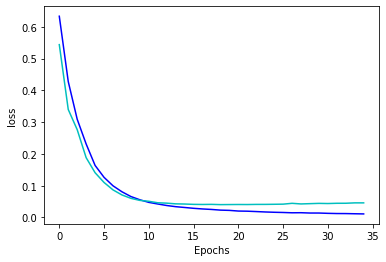

In [37]:
# Visualization of the training process on the loss function 
plt.plot(base_history.history["loss"], color="b")
plt.plot(base_history.history["val_loss"], color="c")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

- Accuracy vs number of epochs

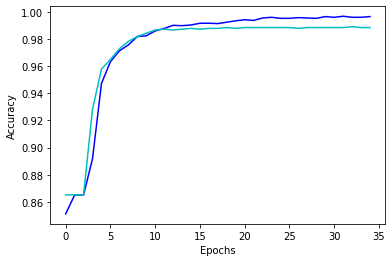

In [38]:
plt.plot(base_history.history["BinaryAccuracy"], color="b")
plt.plot(base_history.history["val_BinaryAccuracy"], color="c")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

- This model is very good as all metrics are closed to 1 on train set while the loss tends to 0
- However it tends to overfit
- Let's try to reduce overfitting by adding a droput layer after each dense layer

## 4-3 Reduce overfitting on base model

- Let's add a dropout layer after each dense layer to reduce overfitting

In [39]:
base_model = tf.keras.Sequential([
                  # layer Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[text.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # dense layer
                  tf.keras.layers.Dense(16, activation='relu'),
                  Dropout(0.2), #prevent overfitting,
                  tf.keras.layers.Dense(8, activation='relu'),
                  Dropout(0.2), #prevent overfitting,

                  # output layer for Binary classification, neuron = 1 + sigmoid. Sigmoid gives a probability
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [40]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 8)             8008      
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                      

In [41]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]
           
optimizer= tf.keras.optimizers.Adam() #Adam (adapts the learning rate depending on the gradient values)

base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), # for Binary Classification
              metrics=metrics)

In [42]:
base_history = base_model.fit(train_batch, 
                    epochs=35, 
                    validation_data=val_batch)

Epoch 1/35
61/61 [==============================] - 2s 9ms/step - loss: 0.6169 - BinaryAccuracy: 0.8614 - precision: 0.1500 - recall: 0.0057 - val_loss: 0.5131 - val_BinaryAccuracy: 0.8651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
61/61 [==============================] - 0s 3ms/step - loss: 0.4188 - BinaryAccuracy: 0.8650 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3365 - val_BinaryAccuracy: 0.8651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/35
61/61 [==============================] - 0s 3ms/step - loss: 0.3267 - BinaryAccuracy: 0.8650 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2793 - val_BinaryAccuracy: 0.8651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/35
61/61 [==============================] - 0s 3ms/step - loss: 0.2674 - BinaryAccuracy: 0.8668 - precision: 1.0000 - recall: 0.0134 - val_loss: 0.2160 - val_BinaryAccuracy: 0.8657 - val_precision: 1.0000 - val_recall: 0.0045
Epoch 5/35
61/61 [======

## 4-4 Evaluation of base model tuned

- Loss vs nb of epochs

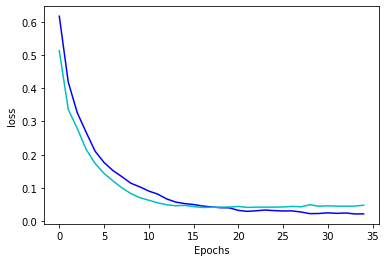

In [43]:
# Visualization of the training process on the loss function 
plt.plot(base_history.history["loss"], color="b")
plt.plot(base_history.history["val_loss"], color="c")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

- Accuracy vs nb of epochs

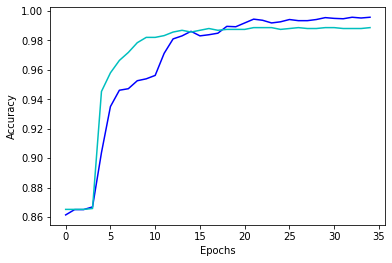

In [44]:
plt.plot(base_history.history["BinaryAccuracy"], color="b")
plt.plot(base_history.history["val_BinaryAccuracy"], color="c")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

- The curves are more closed to each other: overfitting has been reduced
- The performance of this model are good with a Binary accuracy at almost 99% on train set and 98% on test set

# 5- Transfer learning with BERT

## 5-1 Building model

BERT is a pre-trained model. The version used has been pre-trained for English on the Wikipedia and BooksCorpus. 

BERT learns information from both the left and right sides of a token’s context. The Transformer encoder reads the entire sequence of words at once.

Bert model is using strings as an input, so let's go back to the initial dataset and split train and test again

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_def['text_clean'],data_def['target_encoded'], stratify=data_def['target_encoded'])

In [46]:
X_train.head()

2190         man carlos definitely come mu tonight excuse
896                   thursday night yeah sure thing work
2092                             audrie lousy autocorrect
5296                            think steyn surely wicket
4500    gr8 new service   live sex video chat mob   se...
Name: text_clean, dtype: object

- reaching the BERT preprocessor and encoder to generate the model

In [47]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [48]:
# Used in 'basic usage' from this site https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In this model part or all of the inputs are directly connected to the output layer. This architecture makes it possible for the neural network to learn both deep patterns and simple rules.

In [49]:
# Bert layers
#Text input passed to bert_preprocess
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
#Processed text passed to bert_encoder
outputs = bert_encoder(preprocessed_text)

# Neural network layers with Dropout
l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
bert_model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [50]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

- The same metrics and optimizer as above are used 

In [51]:
# define metrics
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

bert_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=METRICS)

In [52]:
# limited to 10 epochs (shutting down for more than 10 epochs in the free version of colab)
history = bert_model.fit(X_train, y_train, epochs=10, validation_data = [X_test,y_test] )

Epoch 1/10
130/130 [==============================] - 2303s 18s/step - loss: 0.3674 - accuracy: 0.8593 - precision: 0.1250 - recall: 0.0071 - val_loss: 0.2795 - val_accuracy: 0.8707 - val_precision: 0.8333 - val_recall: 0.0535
Epoch 2/10
130/130 [==============================] - 2286s 18s/step - loss: 0.2566 - accuracy: 0.8894 - precision: 0.8976 - recall: 0.2036 - val_loss: 0.2114 - val_accuracy: 0.9046 - val_precision: 0.9508 - val_recall: 0.3102
Epoch 3/10
130/130 [==============================] - 2286s 18s/step - loss: 0.2117 - accuracy: 0.9162 - precision: 0.8926 - recall: 0.4304 - val_loss: 0.1794 - val_accuracy: 0.9220 - val_precision: 0.9247 - val_recall: 0.4599
Epoch 4/10
130/130 [==============================] - 2266s 17s/step - loss: 0.1862 - accuracy: 0.9299 - precision: 0.8921 - recall: 0.5464 - val_loss: 0.1611 - val_accuracy: 0.9364 - val_precision: 0.9381 - val_recall: 0.5668
Epoch 5/10
130/130 [==============================] - 2284s 18s/step - loss: 0.1711 - accura

In [53]:
# saving
# bert_model.save("/content/ATT_bert_model.h5")

In [54]:
#import json
# Get the dictionary containing each metric and the loss for each epoch
#bert_history_dict = bert_model.history.history
# Save it under the form of a json file
#json.dump(bert_history_dict, open("/content/ATT_bert_model.h5", 'w'))

# 5-2 Evaluate model

The evaluation of this model will be done in comparison to the base model.
Bert is in red / mangenta in the charts below while the base model is in blue

- loss vs nb of epochs

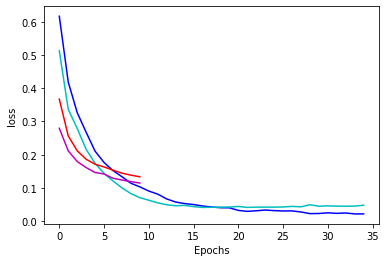

In [55]:
# Visualization of the training process on the loss function 
plt.plot(base_history.history["loss"], color="b")
plt.plot(base_history.history["val_loss"], color="c")
plt.plot(history.history["loss"], color="r")
plt.plot(history.history["val_loss"], color="m")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

- Accuracy vs nb of epochs

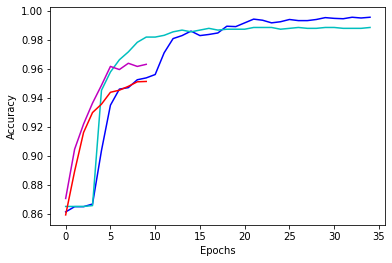

In [56]:
plt.plot(base_history.history["BinaryAccuracy"], color="b")
plt.plot(base_history.history["val_BinaryAccuracy"], color="c")
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="m")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

- Precision vs nb of epochs

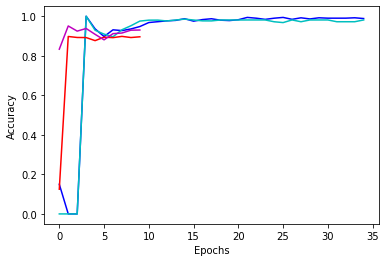

In [57]:
plt.plot(base_history.history["precision"], color="b")
plt.plot(base_history.history["val_precision"], color="c")
plt.plot(history.history["precision"], color="r")
plt.plot(history.history["val_precision"], color="m")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

- Recall vs nb of epochs

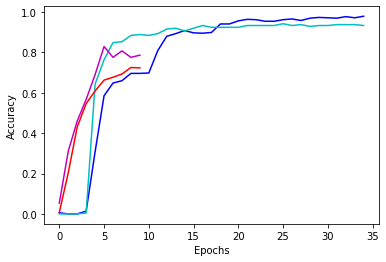

In [58]:
plt.plot(base_history.history["recall"], color="b")
plt.plot(base_history.history["val_recall"], color="c")
plt.plot(history.history["recall"], color="r")
plt.plot(history.history["val_recall"], color="m")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

Based on the 10 first epochs it looks like the basic model tuned is better performing on all the metrics.
BERT model is however less overfitting

# Conclusion

The spam detector built with the basic model tuned performs better than BERT in term of metrics after 10 epochs even if it tends to overfit slightly, and I would recommend this model at this stage.

The BERT model could not be run on 35 epochs as done on the basic model, because of the use of a free version of colab that disconnects the environnement after a certain time while BERT is very long to run.

To go further, would be interesting to run the BERT model with more epochs.